### 0. Imports

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

### 1. Data Load

STL-10 dataset을 이용
- 10개의 label : airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- train 5000 / test 8000

In [2]:
path = './'

# if not exists the path, make the directory
if not os.path.exists(path):
    os.mkdir(path)

# load dataset
train_ds = datasets.STL10(path, split='train', download=True, transform=transforms.ToTensor()) #이미 다운되어있으면 download=False 로 설정할 것.
val_ds = datasets.STL10(path, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [3]:
# define transformation
transformation = transforms.Compose([ # transforms.Compose로 여러 단계를 묶어서 처리
                    transforms.ToTensor(), # numpy array -> tensor
                    transforms.Resize(224) # resize
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

In [4]:
# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

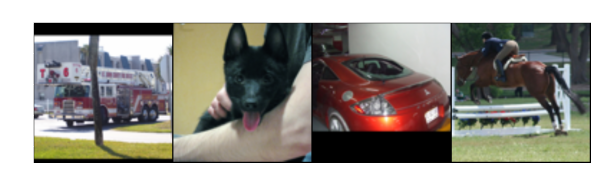

In [5]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(2020)
torch.manual_seed(2020)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

### 2. Built a Model

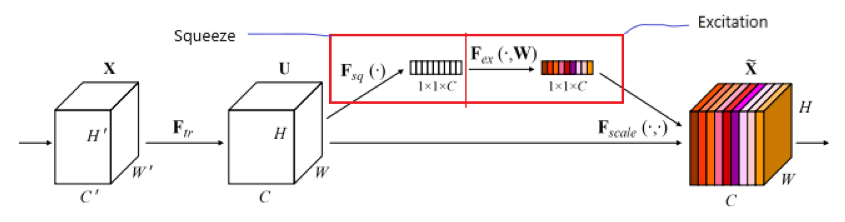

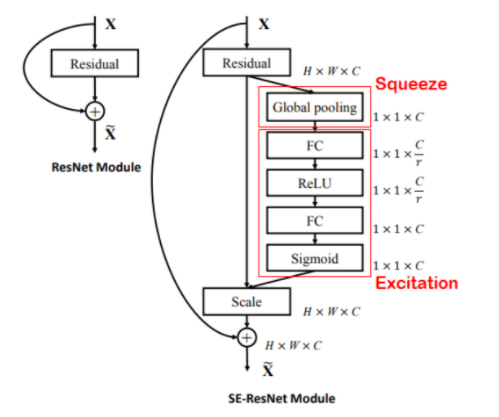

SEBlock은 VGG, GoogleNet, ResNet 등에 첨가되어 성능을 향상시키는 역할을 하는데, 본 구현에서는 코드 예시가 있었던 MobileNetV1에 SEBlock을 적용하고자 함.

In [6]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1)) # GlobalAveragePooling2D 가 PyTorch에서는 AdaptiveAvgPool2d
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r), # FC : C -> C/r
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels), # FC : 다시 C/r -> C
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1) # 1차원으로 flattening
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1) # 다시 4차원 형태로 변환
        return x

In [7]:
# check SEBlock
x = torch.randn(3, 32, 16, 16)
model = SEBlock(32)
output = model(x)
print(output.size())

torch.Size([3, 32, 1, 1])


In [11]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(),
        )

        #self.seblock = SEBlock(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        #x = self.seblock(x) * x
        return x


# BasicConv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )

    def forward(self, x):
        x = self.conv(x)
        return x


# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )
        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )
        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )
        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=10):
    return MobileNet(alpha, num_classes)

In [12]:
# check MobileNetV1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(3, 3, 224, 224).to(device)
model = mobilenet().to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [13]:
# print model summary
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
            ReLU6-10         [-1, 64, 112, 112]               0
        Depthwise-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            ReLU6-14           [-1, 64,

### 3. Training

In [14]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [16]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [17]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
Copied best model weights!
train loss: 1.951369, val loss: 1.845024, accuracy: 28.16, time: 0.5598 min
----------
Epoch 1/99, current lr= 0.01
Copied best model weights!
train loss: 1.683957, val loss: 1.635565, accuracy: 34.80, time: 1.1114 min
----------
Epoch 2/99, current lr= 0.01
train loss: 1.648842, val loss: 1.645472, accuracy: 31.39, time: 1.6639 min
----------
Epoch 3/99, current lr= 0.01
train loss: 1.608591, val loss: 1.823292, accuracy: 31.44, time: 2.2163 min
----------
Epoch 4/99, current lr= 0.01
Copied best model weights!
train loss: 1.514990, val loss: 1.599762, accuracy: 39.73, time: 2.7690 min
----------
Epoch 5/99, current lr= 0.01
train loss: 1.441129, val loss: 1.745771, accuracy: 37.43, time: 3.3200 min
----------
Epoch 6/99, current lr= 0.01
Copied best model weights!
train loss: 1.392396, val loss: 1.414808, accuracy: 46.71, time: 3.8766 min
----------
Epoch 7/99, current lr= 0.01
train loss: 1.299821, val loss: 1.445875, accuracy:

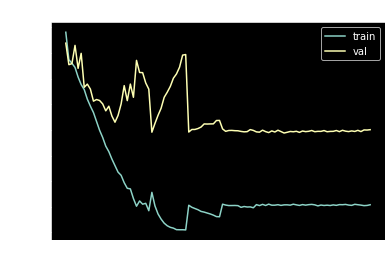

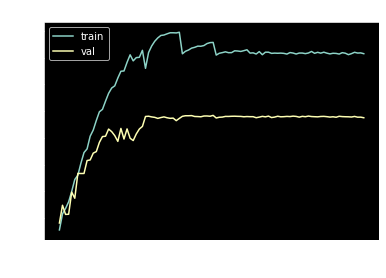

In [18]:
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train_Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()